# SCS 3546 Week 8 – Representational Learning and Variational Methods

---
- **Learning Outcome:** After this module:
    - The learners will have a comprehensive understanding of the generative models and their applications. 
    - The main focus is on Autoencoders and Variational Autoencoders (VAE), motivating the later as a principled approach to generative models. 
    - After finishing this module, the learners will know when and how to train and use (Variational) Autoencoders and,
    - are poised to follow and comprehend new advances in these domains. 
    - Also the module will prepare them for Fully Visible Belief Nets (FVBN) Generative Adversarial Networks (GAN) that are introduced in the following module.
 
- **Topics:**
    - Intro to Generative Models
        - Sample generation by fitting a Gaussian
        - Taxonomy of Generative Models.
    - Autoencoders
        - Theory and Background
        - Hands on Demo
        - Applications: Denoising, Compression, Feature Selection, Image Segmentation, ...
    - Variational Autoencoders
        - Theory
        - *[Optional]* Mathematical background
        - Hands on Demo
 ---

In this module we first introduce the <i>Generative Models</i> and in particular <i>Autoencoders</i>. We will cover a particular type of Autoencoders, <i>Variational Autoencoders</i>, and finally we will explore the applications of these methods in denoising and regularization.

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Generative-Models-" data-toc-modified-id="Generative-Models--1">Generative Models <a class="anchor" id="generative-models"></a></a></span><ul class="toc-item"><li><span><a href="#A-Familiar-Example:-Naive-Bayes" data-toc-modified-id="A-Familiar-Example:-Naive-Bayes-1.1">A Familiar Example: Naive Bayes</a></span></li><li><span><a href="#Taxonomy-of-Generative-Models" data-toc-modified-id="Taxonomy-of-Generative-Models-1.2">Taxonomy of Generative Models</a></span></li></ul></li><li><span><a href="#Autoencoders" data-toc-modified-id="Autoencoders-2">Autoencoders</a></span><ul class="toc-item"><li><span><a href="#Autoencoders:-Demo" data-toc-modified-id="Autoencoders:-Demo-2.1">Autoencoders: Demo</a></span></li><li><span><a href="#Applications" data-toc-modified-id="Applications-2.2">Applications</a></span><ul class="toc-item"><li><span><a href="#Denoising" data-toc-modified-id="Denoising-2.2.1">Denoising</a></span></li><li><span><a href="#Compression" data-toc-modified-id="Compression-2.2.2">Compression</a></span></li><li><span><a href="#Image-Segmentation" data-toc-modified-id="Image-Segmentation-2.2.3">Image Segmentation</a></span></li></ul></li></ul></li><li><span><a href="#Variational-Autoencoders" data-toc-modified-id="Variational-Autoencoders-3">Variational Autoencoders</a></span><ul class="toc-item"><li><span><a href="#VAE:-Demo" data-toc-modified-id="VAE:-Demo-3.1">VAE: Demo</a></span></li></ul></li><li><span><a href="#Resources" data-toc-modified-id="Resources-4">Resources</a></span></li></ul></div>

## Generative Models <a class="anchor" id="generative-models"></a>

So far we have been talking about **Discriminative** models where the goal is to estimate the conditional probability of a target value $Y$ given the observable value $x = (x_1, ..., x_d)$, symbolically $P(Y|X=x)$. In other words, if $x$ is the data (e.g. a picture) and $y$ is a label (e.g. "Cat") our aim is to learn a *function* that maps $x\rightarrow y$. These models are almost always trained in a *supervised* manner such as classification, regression, object detections, ... .

<img src="vae_img/cat_image.png" width="400">


There is an alternative class of machine learning algorithms that learn the conditional probability of a given observable $x$, given a target value y, or $P(X|Y=y)$. This class of learning models are called **Generative** algorithms and the reason behind this, as we shall see later, is that once you have a generative model you can generate new samples from the conditional probability distribution for any given class. For example we can ask the model to generate more "Cat" pictures.



### A Familiar Example: Naive Bayes

Let's take a detour and introduce the concept via a familiar and simple generative model: Naive Bayes. A supervised classification algorithm, Naive Bayes estimates $P(Y|X=x)$, but it does so by first estimating the class model $P(X|Y=y)$ and prior $P(Y)$ followed by the application of the Bayes rule to find the most probable class label for a given example $x$:

\begin{equation}
P(Y|X=x) = \underset{y}{\arg\max} \frac{P(X|Y=y)P(Y=y)}{P(X)}
\end{equation}

Here: 
 - $P(Y|X=x)$ is the **posterior** probability or the probability of $Y$ being the true label of the observation $x$,
 - $P(X|Y=y)$ is the **class model** or the probability of observing an example given a class label,
 - $P(Y)$ is the **prior** probability or the knowledge about the observance of $Y$ before any evidence like $X$ is taken into account. In other words, it signifies which classes are more likely and which are more rare.
 - And finally, $\underset{x}{\arg\max} f(x)$, returns the value for $x$ that maximizes $f(x)$.

The denominator does not affect the prediction in the argmax equation, so we can drop it and put $P(Y|X=x)\approx P(X|Y=y)P(Y)$. In addition, we make the (Naive) *independence assumption* which is at the heart of Naive Bayes. We assume that given $y$, the x_1, ..., x_d are conditionally independent. This turns the previous inequality to:

\begin{equation}
P(Y|X=x)\approx P(X|Y=y)P(Y)\approx P(Y)\prod_{i=1}^{d}P(x_i|Y)
\end{equation}

The independence assumption makes the problem tractable, allowing each $P(x_i|Y)$ to be learned independently. A sensible assumption in order to make the math simpler is to assume that $P(x_i|Y)$ follows a Gaussian distribution (making $P(X|Y)$ a multivariate Gaussian). Then by using the "counting method" we can measure the mean and the variance of the distribution for each class value $Y=y$. Note that at this point we have a model that can *generate* new samples with label $y$ by sampling the multivariate Gaussian $P(X|Y=y)$.

Let's try this on the MNIST dataset. Note that here we do not care much about the discriminative power of Naive Bayes on MNIST but rather want to see if we can generate images of digits by sampling the fitted class model.

Let's download MNIST and fit a Gaussian Naive Bayes model to it:

In [1]:
%matplotlib inline

In [2]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data

from sklearn.naive_bayes import GaussianNB
from sklearn.datasets import fetch_mldata

from matplotlib import pyplot as plt
import matplotlib
import numpy as np


# Fetch mnist data
mnist = input_data.read_data_sets('MNIST_data')

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [3]:
gnb = GaussianNB()
gnb.fit(mnist.train.images, mnist.train.labels)

GaussianNB(priors=None, var_smoothing=1e-09)

As a sanity check, let's draw the mean of each of the 10 classes. Here we use ```gnb.theta_``` which is a $10\times784$ array: $10$ is the number of classes (digits) and $784=28\times28$ is the number of pixels in each image. ```gnb.theta_``` stores the mean value of each pixel in each class:

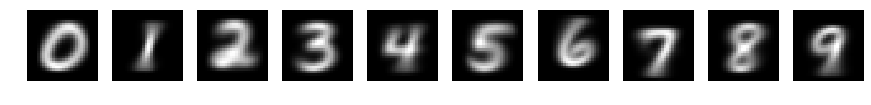

In [4]:
width=15
fig = plt.figure(figsize=(width, width/2.5))

for i in range(10):
    mean_image = np.array(gnb.theta_[i], dtype='float')
    pixels = mean_image.reshape((28, 28))
    
    sub = fig.add_subplot(1, 10, i + 1)
    sub.imshow(pixels, interpolation='nearest', cmap='gray')
    plt.axis('off')

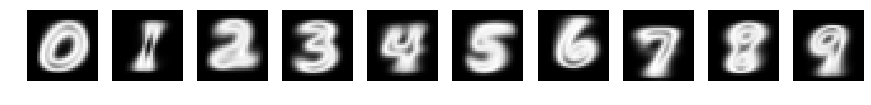

In [5]:
width=15
fig = plt.figure(figsize=(width, width/2.5))

for i in range(10):
    mean_image = np.array(gnb.sigma_[i], dtype='float')
    pixels = mean_image.reshape((28, 28))
    
    sub = fig.add_subplot(1, 10, i + 1)
    sub.imshow(pixels, interpolation='nearest', cmap='gray')
    plt.axis('off')

Now that we have the mean and variance of each class samples, we can use the resulting Gaussian distribution and generate samples from each class by sampling each pixel from the learned Gaussian distribution. Here we generate two sets of samples (`no_of_sets`):

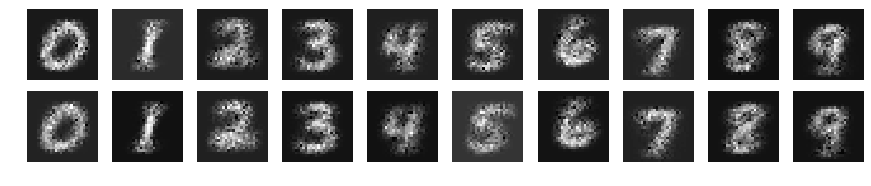

In [6]:
fig = plt.figure(figsize=(15, 3))
fig.tight_layout()
no_of_sets = 2

for i in range(no_of_sets * 10):
    n = i%10
    mean = np.array(gnb.theta_[n], dtype='float') # mean of all samples of class n (e.g. mean of all '7's)
    std  = np.array(gnb.sigma_[n], dtype='float') # std  of all samples of class n (e.g. std  of all '7's)
    rand_image = np.random.normal(mean, std) # <<<<<<<<<<< Image generation happens here <<<<<<<<<
    pixels = rand_image.reshape((28, 28))
    
    sub = fig.add_subplot(2, 10, i + 1)
    sub.imshow(pixels, cmap='gray')
    plt.axis('off')
plt.subplots_adjust(hspace = 0.001)

<div class="alert alert-block alert-warning">
<b>Note:</b> Here we generated samples conditioned on the class labels, for example we sample from $P(X|Y=7)$ to generate pictures showing number 7, this type of sampling is called "class-conditioned" sampling. However normally in generative models literature, and the rest of the notebook, the density estimation and subsequent sampling is done for $P(X)$.
</div>

So far we have used a generative model to create new samples from the fitted distribution. However, the samples that are generated look more or less like the mean images shown before and they do not look a lot like actual samples from MNIST shown here:

<img src="vae_img/mnist_digits.png" width="800">

The reason behind this is that Naive Bayes by nature is too simple and fails to model data well, mostly due to the conditional independence assumption we made earlier. In other words, the value of pixels are estimated completely independent of one another and our model is just generating samples by perturbing the mean value of every pixel according to the fitted Gaussian to that pixel. The generative models that we talk about in the rest of this notebook (and later on in *Generative Adversarial Networks* module) have much higher capacity to produce never seen before samples that still resemble the training examples.


### Taxonomy of Generative Models
The models that we focus on here are all trained in an *Unsupervised* manner. Unlike supervised learning where we have data and label pairs $(x, y)$, here we just have the data and our goal is to learn some underlying hidden structure of the data. In other words, we would like to fit a probability density function to the given data $P_{data}(x)$ that can estimate the actual density function from which the data was originally generated: $P_{model}(x)$. This is called *density estimation*. After $P_{data}(x)$ is learned, we can then generate images as if we had access to $P_{model}(x)$.

The density estimation can be done in two ways:
 - **Explicit density estimation**: Write down a density function and fit the parameters to the data
 - **Implicit density estimation**: Learn a model that can sample from $P_{model}(x)$ without explicitly defining it.
 
In our toy example for Naive Bayes, after measuring the data probabilities, we explicitly defined the density function to be a Gaussian and fit its parameters (mean and variance) according to the observed samples. So we did an explicit density estimation.

Given this distinction, we can form a taxonomy for generative models:

<figure>
    <img src="vae_img/Taxonomy.png" width="620">
    <figcaption>
        <center>Goodfellow, I. (2016), Generative Adversarial Networks - NIPS 2016 tutorial. </center><center>Retrieved from https://www.youtube.com/watch?v=HGYYEUSm-0Q</center></figcaption>
</figure>

In this module we will only focus on the <font color='#c92d39'>**Variational Autoencoders (VAE)**</font>. In a later module we will touch on the <font color='#c92d39'>**Fully Visible Belief Networks**</font> and we contrast their density function with that of the VAE's and talk more exclusively about <font color='#c92d39'>**Generative Adversarial Networks (GANs)**</font>.



## Autoencoders

Before we can dive into VAE's and how they can solve the problem of the last section, we have to first introduce <font color='#c92d39'>**Autoencoders**</font>. Autoencoders are classified as an unsupervised learning technique and they use different kinds of neural networks in order to reduce the dimensionality of the input data. In other words, Autoencoders compress a high dimensional input into a smaller representation. They do this by enforcing a "*bottleneck*" on the network. The idea is to pass the input through a series of hidden layers and on the other side try to reconstruct the input. This way the bottleneck in the network is forced to learn a *representation* of the given input: a hidden structure behind the input data.

<img src="vae_img/Autoencoder.png" width="900">

In the above picture we see the high dimensional input (which is an image in this case) is passed through a fully connected layer and in the middle a lower dimensional representation of the input is constructed. Later the reverse process is applied to reconstruct the given image. The first segment of the network is called an *Encoder* and the second segment is called a *decoder*. The space of the compressed representations is sometimes called the *latent* or *feature space*. Note that the encoder and the decoder networks can be fully connected, convolutional or any other type of a network.

The loss function for this task is simply the reconstruction error: $||x-x'||^2$, which measures the differences between the original input and the generated output.

The question is why do we want to compress the information about the input in a lower dimensional space at all? The answer is that by doing this, we are encapsulating the most important features of X in that lower dimensional vector. This is exactly the reason why we do *Principal Components Analysis (PCA)*. In fact if we get rid of the activation functions in the above network and only use linear units, we get the same effect as PCAs (Check out Geoffrey Hinton's __[video](https://www.coursera.org/lecture/neural-networks/from-pca-to-autoencoders-5-mins-JiT1i)__ regarding this).

So after training the whole network, we can get rid of the decoder and use the feature vector that comes out of the encoder for other classification tasks:


<img src="vae_img/Autoencoder%20%282%29.png" width="670">

This is a common practice when our training set is small. So we can spend some time training the Autoencoder in order to initialize our classification task with the hope that the encoder then can capture the most important features of the data distribution and can aid the classifier.

<div class="alert alert-block alert-warning">
<b>Note:</b> For dimensionality reduction, contrary to PCA that discovers a lower dimensional hyperplane to describe the data, the Autoencoders, with their non-linear activation functions, can capture more generalized non-linear *manifolds*. So in that regard the Autoencoders are more powerful than PCA's. The following image shows this difference:


<figure>
    <img src="vae_img/Screen-Shot-2018-03-07-at-8.52.21-AM.png" width="400">
    <figcaption>
        <center>Jordan, J. (2018, March). Introduction to Autoencoders. </center><center>Retrieved from https://www.jeremyjordan.me/autoencoders/</center></figcaption>
</figure>

</div>

### Autoencoders: Demo

So now that we know the theory and intuition behind Autoencoders, let's write our own with TensorFlow. We use the same MNIST dataset as before, so let's see if this method can generate more satisfying images. Just a note that in each minibatch training phase, we plot a few samples. For each sample, we plot the original image, its encoded vector representation (3 nodes by default) and the reconstructed version of the image. You can set the `latent_size` to change the dimensionality (number of neurons) of the latent space and see it's effect on the accuracy of the reconstructed images.

<img src="vae_img/AE_anim.gif" width="800">


This way we can see the progression of the training algorithm:

In [6]:
%matplotlib notebook

import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data

tfd = tf.contrib.distributions

# Latent Space Size
latent_size = 3

# Training Parameters
learning_rate = 0.01
num_steps = 500#10000
batch_size = 256

# Output Config Parameters
display_step = 1000
examples_to_show = 10

# Size of an MNIST image (28*28 pixel)
num_input = 784 

X = tf.placeholder(tf.float32, [None, num_input])

# Building the encoder (4 hidden layers)
def encoder(x):
    h0 = tf.layers.dense(x, 128, tf.nn.tanh)
    h1 = tf.layers.dense(h0, 64, tf.nn.tanh)
    h2 = tf.layers.dense(h1, 12, tf.nn.tanh)
    return tf.layers.dense(h2, latent_size)

# Building the decoder (4 hidden layers)
def decoder(x):
    de0 = tf.layers.dense(x, 12, tf.nn.tanh)
    de1 = tf.layers.dense(de0, 64, tf.nn.tanh)
    de2 = tf.layers.dense(de1, 128, tf.nn.tanh)
    return tf.layers.dense(de2, num_input, tf.nn.sigmoid)

# Connecting things up
encoder_op = encoder(X)
decoder_op = decoder(encoder_op)

# Since we want to reconstrcut the image, we use X as label in our loss function
loss = tf.losses.mean_squared_error(labels=X, predictions=decoder_op)
train = tf.train.AdamOptimizer(learning_rate).minimize(loss)

sess = tf.Session()
sess.run(tf.global_variables_initializer())

# initialize figure
f, a = plt.subplots(3, examples_to_show, figsize=(examples_to_show, 3))
f.tight_layout()
plt.ion()   # continuously plot

# original data (first row) for viewing
view_data = mnist.test.images[:examples_to_show]
for i in range(examples_to_show):
    a[0][i].imshow(np.reshape(view_data[i], (28, 28)), cmap='gray')
    a[0][i].set_xticks(()); a[0][i].set_yticks(())

for step in range(num_steps):
    b_x, _ = mnist.train.next_batch(batch_size)
    _, encoded_, decoded_, loss_ = sess.run([train, encoder_op, decoder_op, loss], {X: b_x})

    if step % 100 == 0: # plotting
        print('step: {0}, train loss: {1:.4f}'.format(step, loss_))
        
        encoded_data = sess.run(encoder_op, {X: view_data})
        decoded_data = sess.run(decoder_op, {X: view_data})
        for i in range(examples_to_show):
            # plotting encoded vector (second row)
            a[1][i].clear()
            a[1][i].imshow(np.reshape(encoded_data[i], (1, latent_size)), cmap='YlOrBr')
            a[1][i].set_xticks(()); a[1][i].set_yticks(())
            # plotting decoded image (third row)
            a[2][i].clear()
            a[2][i].imshow(np.reshape(decoded_data[i], (28, 28)), cmap='gray')
            a[2][i].set_xticks(()); a[2][i].set_yticks(())
            
        plt.pause(0.01)
        f.canvas.draw()

plt.ioff()

Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


<IPython.core.display.Javascript object>

step: 0, train loss: 0.2318
step: 100, train loss: 0.0609
step: 200, train loss: 0.0573
step: 300, train loss: 0.0552
step: 400, train loss: 0.0529


<IPython.core.display.Javascript object>

### Applications

Feature selection is only one of the applications of Autoencoders. There are so many other areas that Autoencoders have been used very successfully. In this section we briefly go over a few of those areas:

#### Denoising
So far during training, we use the input image $x$ as both the input and the target and we built our target by minimizing the reconstruction loss compared to $x$. What happens if we slightly corrupt the data by adding some noise to $x$ and making a noisy version called $\tilde{x}$. So the input to the network will be $\tilde{x}$ and the target is still $x$. 

<img src="vae_img/dAE.png" width="800">

Note that in this case, the mapping that the network is trying to find is not from the image to itself but rather from a noisy version to the uncorrupted version. This makes the network more generalizable by reducing the chance of memorization of the input but also can be used as a denoising mechanism. In the picture below, we see the effect of applying a *Denoising Autoencoder (dAE)* to the MNIST dataset.  

<figure>
    <img src='vae_img/dAE_result.png' width="600">
    <figcaption><center>Left: original test images. Center: corrupted (noisy) images. Right: reconstructed images (output).</center>
        <center>[Image credit: OpenDeep. Tutorial: Your First Model (DAE)</center><center>Retrieved from http://www.opendeep.org/v0.0.5/docs/tutorial-your-first-model ]</center></figcaption>
</figure>

#### Compression
Since the encoded image is often much smaller than the original, the Autoencoders can be used very effectively in (Lossy) image compression. There has been a lot of research in using *Convolutional Autoencoders (CAE)* for image compression. The idea is to pass the image through a type of a convolutional encoder and get a compressed image. The compressed image can then be transferred over the network and at the destination the decoder passes the image through deconvolutional layers to obtain the original image. In the following picture we can compare the state of the art autoencoder compression technique with classical compression methods (JPEG & JPEG2000):

<p>
<figure>
    <img src='vae_img/Compression_AE.png' width="600">
    <figcaption><center>Raw image (a) and reconstructed images (300 × 300) cropped from Kodak images using (b)JPEG, (c)JPEG2000 and (d)CAE.</center>
        <center>[<b>Image credit:</b> Cheng, Z., Sun, H., Takeuchi, M., & Katto, J. (2018). Deep Convolutional AutoEncoder-based Lossy Image Compression. 2018 Picture Coding Symposium (PCS).]</center></figcaption>
</figure>
<p>

#### Image Segmentation
In the Deep Computer Vision module we got introduced to the concept of image segmentation. That is another important application of the Autoencoders. In the denoising section we saw what happens if the input and output of an Autoencoder are different and a similar approach has be adopted for image segmentation. You take an input image, you run it through the conv encoder and it is remapped to the target image but instead of reconstructing the original image, we set the segmented version of the original image. So the Autoencoder is trained to segment the image. 
<p>
<figure>
    <img src='vae_img/Segmentation_AE.png' width="600">
    <figcaption><center>[<b>Image credit:</b> Badrinarayanan, V., Kendall, A., & Cipolla, R. (2017). SegNet: A Deep Convolutional Encoder-Decoder Architecture for Image Segmentation. IEEE Transactions on Pattern Analysis and Machine Intelligence, 39(12), 2481-2495.]</center></figcaption>
</figure>
</p>
As we saw before image segmentation has many applications specially in self-driving cars, in order to differentiate different *types* of objects that are present at any given time that the car needs to detect. In the following image we see a few sample images along with their segmented version. Take a look at SegNet's [website](http://mi.eng.cam.ac.uk/projects/segnet). You can upload your own image and segment it online.

<p>
<figure>
    <img src='vae_img/Segments.png' width="600">
    <figcaption><center>[<b>Image credit:</b> Badrinarayanan, V., Kendall, A., & Cipolla, R. (2017). SegNet: A Deep Convolutional Encoder-Decoder Architecture for Image Segmentation. IEEE Transactions on Pattern Analysis and Machine Intelligence, 39(12), 2481-2495.]</center></figcaption>
</figure>
</p>


## Variational Autoencoders

We began our conversation of generative models with the idea of finding a distribution $P_{data}(x)$ that can mimic the true underlying distribution $P_{model}(x)$ from which our training samples were generated. Our goal was then to be able to sample from $P_{data}(x)$ to generate never seen before instances. In autoencoders, we saw that the decoder can map values from the latent space to actual images in the original dataset. So prehaps we can generate images by sampling from the latent space and feeding it to the decoder. In fact we can do that by perturbing the encoded values of actual images in our training set and get somewhat different decoded images. But that wouldn't get us too far. Since we don't really know the underlying distribution of the latent space, the images that we generate by small perturbations would be very similar to the images in the training set and we will end up with the same problem as in the Naive Bayes section. If we perturb the images too much, again because we don't know the correct distribution of the latent space, might not look like images at all.

Variational Autoencoders solve this issue in a very elegant way. What if we force the Autoencoder to learn a distribution as the latent variables instead of just single values? In other words, let's constrain the encoder to generate latent vectors that approximate a known distribution, like unit Gaussian. This way generating new images would be easy. All we have to do is to sample from the learned Gaussian and pass the result through the decoder network. This constraint over the latent space is the difference between a variational Autoencoder and a vanilla one.

The new end-to-end network looks like this:

<img src="vae_img/VAE.png" width="900">

The last layer of the encoder network generates the $\mu$ and $\sigma$ of the Normal distribution, from which a sample is taken that is our new latent vector $z$. The rest is like a normal decoder. Notice that here the network has to solve a trade-off. From one hand, it has to reduce the reconstruction loss (as before), on the other hand, it has to force the latent variables to match the Normal distribution. For the former, we can use a **negative log-likelihood** or **Mean-Squared Error**, which we know from previous modules. For the later, we use  **Kullback-Leibler divergence** (in short KL-divergence) that captures how different two probability distributions are from one another. 

From Wikipedia: *for discrete probability distributions $P$ and $Q$ defined on the same probability space, the Kullback–Leibler divergence from Q to P is defined to be:*
    
\begin{equation}
    \mathcal{D}_\text{KL}(P \| Q) = -\sum_i {P(i)\, \log\left(\frac{Q(i)}{P(i)}\right)}.
\end{equation}

Replace the summation with an integral for continuous distributions.

So overall our loss function for a reconstructed image $x'$ of $x$ would be:

\begin{align}
    L_{reconst} &= \|x - x'\|^2\\
    L_{latent}  &= \mathcal{D}_{KL}(z \| \mathcal{N}(0, 1))\\
    Loss &= L_{reconst} + L_{latent}
\end{align}

<div class="alert alert-block alert-warning">
<b>The math under the hood:</b> Without getting into too many details about the mathematical derivations of VAE's loss function, we present a high-level view of some of the concepts that are important in understanding the code in the demo section.

First, the true loss function of a VAE for a single sample $i$, is given by the following:

<img src="vae_img/VAE_loss.png" width="500">

<p>
The first term is the reconstruction loss which is given as the expectation over the negative log-likelihood of decoded images. The latent values are sampled from the encoder: $z\sim q_{\theta}(z|x_i)$ and they are reconstructed by the decoder $p_{\phi}(x_i | z)$. The $q_{\theta}(z|x_i)$ is a Gaussian approximation of the true (but intractable) posterior $p_{\theta}(z|x_i)$. The choice of $p_{\phi}(x_i | z)$ depends on the application, and can be Gaussian for real-valued or Bernoulli for binary data. For our MNIST demo example bellow we choose Bernoulli and as a result our reconstruction loss can be a simple *Cross-Entropy* loss.
    
As for the second term, under certain assumptions, we can find an analytical solution for the KL term:

<img src="vae_img/kl_term.png" width="500">
This is what we use in our code example bellow.
</p>

</div>

### VAE: Demo

Let's get back to the MNIST dataset and try generating new samples using VAE's. 

Instructions for updating:
Use tf.cast instead.
Step 1, Loss: 544.819031


/Users/derekpyne/.local/share/virtualenvs/ml_playground-ftQOzaS6/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


Step 1000, Loss: 185.885345
Step 2000, Loss: 180.157791
Step 3000, Loss: 167.033875
Step 4000, Loss: 168.713745
Step 5000, Loss: 163.443268
Step 6000, Loss: 167.286804
Step 7000, Loss: 158.894531
Step 8000, Loss: 172.782471
Step 9000, Loss: 157.190369
Step 10000, Loss: 155.553528
Step 11000, Loss: 148.656189
Step 12000, Loss: 169.208679
Step 13000, Loss: 151.049850
Step 14000, Loss: 154.548538
Step 15000, Loss: 156.553986
Step 16000, Loss: 148.532349
Step 17000, Loss: 157.903259
Step 18000, Loss: 142.739410
Step 19000, Loss: 154.753036
Step 20000, Loss: 158.672287
Step 21000, Loss: 155.527313
Step 22000, Loss: 145.417145
Step 23000, Loss: 153.994507
Step 24000, Loss: 162.508362
Step 25000, Loss: 150.571838
Step 26000, Loss: 166.244339
Step 27000, Loss: 155.627197
Step 28000, Loss: 151.165359
Step 29000, Loss: 156.703491


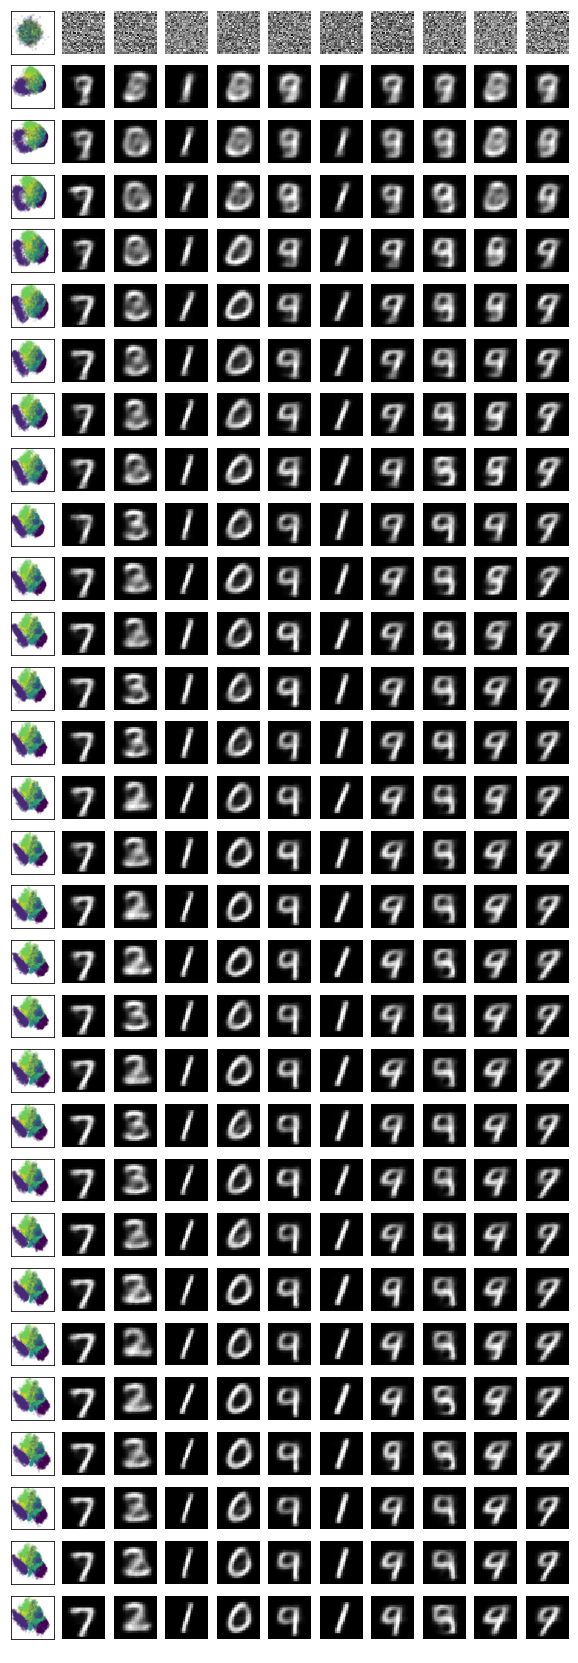

In [8]:
%matplotlib inline

tf.reset_default_graph()

# Parameters
learning_rate = 0.001
num_steps = 30000
epoch_size = 1000
batch_size = 64

# Network Parameters
image_dim = 784 # MNIST images are 28x28 pixels
hidden_dim = 512
latent_dim = 2

# Building the encoder
X = tf.placeholder(tf.float32, shape=[None, image_dim])
latent = tf.placeholder(tf.float32, shape=[None, latent_dim])

# Building the encoder 
def encoder(x):
    h0 = tf.layers.dense(x, hidden_dim, tf.nn.tanh)
    z_mean = tf.layers.dense(h0, latent_dim) #hidden_dim X latent_dim
    z_std = tf.layers.dense(h0, latent_dim)
    return z_mean, z_std

# Sampler: Normal (gaussian) random distribution
def sampler(z_mean, z_std):
    eps = tf.random_normal(tf.shape(z_std), dtype=tf.float32, mean=0., stddev=1.0,
                       name='epsilon')
    
    return z_mean + tf.exp(z_std / 2) * eps

# Building the decoder 
# (Note that we expose the 'reuse' flag so that we can reuse the decoder to make samples later)
def decoder(z, reuse=False):
    h0 = tf.layers.dense(z, hidden_dim, tf.nn.tanh, name="dh0", reuse = reuse)
    h1 = tf.layers.dense(h0, image_dim, tf.nn.sigmoid, name="dh1", reuse = reuse)
    
    return h1


# Define VAE Loss
def vae_loss(x_reconstructed, x_true, z_mean, z_std):
    # Reconstruction loss
    encode_decode_loss = x_true * tf.log(1e-10 + x_reconstructed) \
                         + (1 - x_true) * tf.log(1e-10 + 1 - x_reconstructed)
    encode_decode_loss = -tf.reduce_sum(encode_decode_loss, 1)
    # KL Divergence loss
    kl_div_loss = 1 + z_std - tf.square(z_mean) - tf.exp(z_std)
    kl_div_loss = -0.5 * tf.reduce_sum(kl_div_loss, 1)
    return tf.reduce_mean(encode_decode_loss + kl_div_loss)

mean_op, std_op = encoder(X)
z_op = sampler(mean_op, std_op)

decoder_op = decoder(z_op)
loss_op = vae_loss(decoder_op, X, mean_op, std_op)

optimizer = tf.train.RMSPropOptimizer(learning_rate=learning_rate)
train_op = optimizer.minimize(loss_op)

noise_input = tf.placeholder(tf.float32, shape=[None, latent_dim])
# Initialize the variables (i.e. assign their default value)
init = tf.global_variables_initializer()

def plot_codes(ax, codes, labels):
    ax.scatter(codes[:, 0], codes[:, 1], s=2, c=labels, alpha=0.1)
    ax.set_aspect('equal')
    ax.set_xlim(codes.min() - .1, codes.max() + .1)
    ax.set_ylim(codes.min() - .1, codes.max() + .1)
    ax.tick_params(
        axis='both', which='both', left='off', bottom='off',
        labelleft='off', labelbottom='off')
    
def plot_samples(ax, samples):
    samples = samples.reshape([-1, 28, 28])
    for index, sample in enumerate(samples):
        ax[index].imshow(sample, cmap='gray')
        ax[index].axis('off')

examples_to_show = 10
nrows = int(num_steps/epoch_size)
fig, ax = plt.subplots(nrows=nrows, ncols=examples_to_show+1, figsize=(examples_to_show, nrows))

# Start Training
# Start a new TF session
sess = tf.Session()
sess.run(init) # Run the initializer

# Training
for step in range(1, num_steps):
    # Prepare Data
    # Get the next batch of MNIST data (only images are needed, not labels)
    batch_x, _ = mnist.train.next_batch(batch_size)

    # Train
    _, loss_ = sess.run([train_op, loss_op], feed_dict={X: batch_x})
    
    if step % epoch_size == 0 or step == 1:        
        print('Step %i, Loss: %f' % (step, loss_))
        epoch = int(step / epoch_size)
        
        encoded_data = sess.run(z_op, feed_dict={X: mnist.test.images})
        decoded_data = sess.run(decoder_op, feed_dict={X: mnist.test.images[:examples_to_show]})
        
        plot_codes(ax[epoch, 0], encoded_data, mnist.test.labels)
        plot_samples(ax[epoch, 1:], decoded_data)

fig.canvas.draw()

Note that the first column shows the distribution of the latent space by passing through all of the MNIST samples through the encoder network and plotting them in 2-d space (our latent space is 2 dimensional here). Notice how the samples move in the space and form clusters as we keep on training. 

In the following code snippet, we show the final result. We have color coded the different samples based on their labels. 

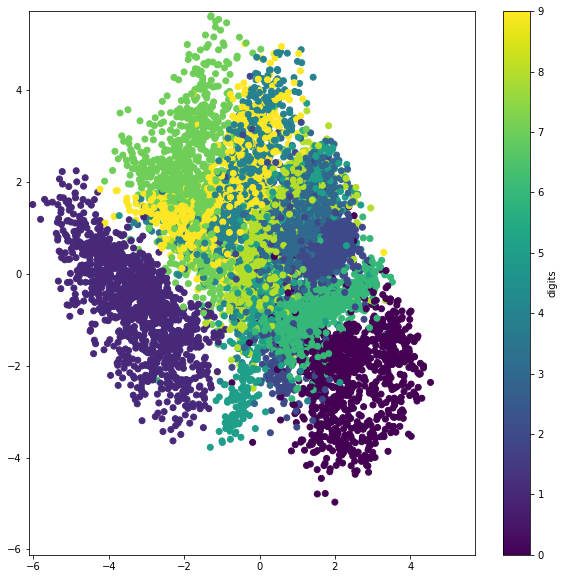

In [9]:
%matplotlib inline
# Use this for the Nice scatter plot form Keras notebook
fig, ax = plt.subplots(figsize=(10, 10))
# ax = fig.add_subplot(1, 1)
encoded_data = sess.run(z_op, feed_dict={X: mnist.test.images})
# plot_codes(fig, encoded_data, mnist.test.labels)

ax.scatter(encoded_data[:, 0], encoded_data[:, 1], c=mnist.test.labels)

ax.set_xlim(encoded_data.min() - .1, encoded_data.max() + .1)
ax.set_ylim(encoded_data.min() - .1, encoded_data.max() + .1)
ax.tick_params(
    axis='both', which='both')

plt.colorbar(ax.get_children()[0], ax=ax, label='digits') 
plt.show()

Now let's generate some digits by feeding the encoder with some noise input over a range of values. Notice how the shape of the digist can change depending on the noise value:

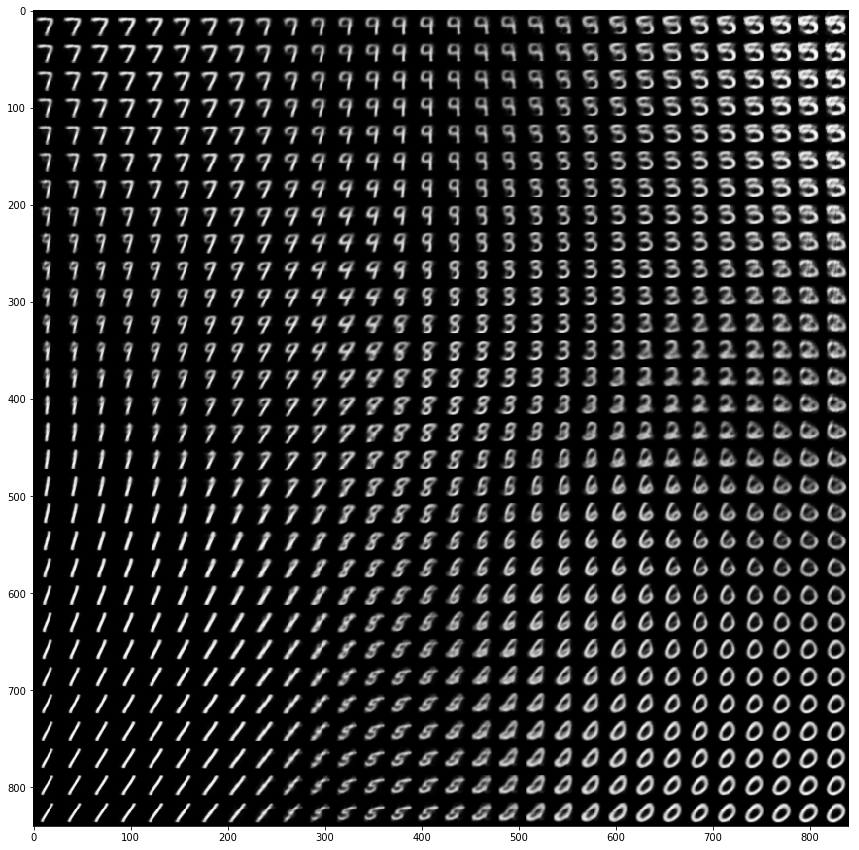

In [10]:
%matplotlib inline
# Testing
decoder_noise_op = decoder(noise_input, reuse=True)
# Building a manifold of generated digits
n = 30
x_axis = np.linspace(-3, 3, n)
y_axis = np.linspace(-3, 3, n)

canvas = np.empty((28 * n, 28 * n))
for i, yi in enumerate(x_axis):
    for j, xi in enumerate(y_axis):
        z_mu = np.array([[xi, yi]] * batch_size)
        x_mean = sess.run(decoder_noise_op, feed_dict={noise_input: z_mu})#decoder, feed_dict={noise_input: z_mu})
        canvas[(n - i - 1) * 28:(n - i) * 28, j * 28:(j + 1) * 28] = \
        x_mean[0].reshape(28, 28)

plt.figure(figsize=(15, 15))
Xi, Yi = np.meshgrid(x_axis, y_axis)
plt.imshow(canvas, origin="upper", cmap="gray")
plt.show()

This shows how the latent space has captured structural properties that we can take advantage of in order to produce a diverse set of samples. In real world images this translates to being able to control some facial features of a person, or rotate the head, etc:


<p>
<figure>
    <img src="vae_img/faces.png" width="500">
    <figcaption><center>[<b>Image credit:</b> Higgins, I., Matthey, L., Pal, A., Burgess, C., Glorot, X., Botvinick, M., ... & Lerchner, A. (2016). beta-vae: Learning basic visual concepts with a constrained variational framework.]</center></figcaption>
</figure>
</p>


## Resources

1. Generative models
    - https://www.youtube.com/watch?v=5WoItGTWV54&t=1330s
    - http://videolectures.net/deeplearning2017_goodfellow_generative_models/
2. Representation Learning
    - https://arxiv.org/pdf/1206.5538.pdf	
3. Autoencoders
    - https://github.com/aymericdamien/TensorFlow-Examples/blob/master/notebooks/3_NeuralNetworks/autoencoder.ipynb
    - https://www.youtube.com/watch?v=KSYztoOtCo0
    - https://www.youtube.com/watch?v=H3sg6K5iDBM
    - https://blog.keras.io/building-autoencoders-in-keras.html [Good for denoising topic]
4. Variational autoencoders
    - https://hsaghir.github.io/data_science/denoising-vs-variational-autoencoder/
    - https://jaan.io/what-is-variational-autoencoder-vae-tutorial/
    - https://arxiv.org/pdf/1606.05908.pdf
    - http://kvfrans.com/variational-autoencoders-explained/
    - https://wiseodd.github.io/techblog/2017/01/24/vae-pytorch/
5. Further reading: 
    - https://arxiv.org/pdf/1711.05597.pdf
    - https://arxiv.org/pdf/1606.05908.pdf
    - https://www.youtube.com/watch?v=9zKuYvjFFS8
